# XGBoost - Wine Quality (Regression)

[UCI - Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality)

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
df = pd.read_csv('./data/wine_concat.csv')

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,red


In [6]:
df.isnull().sum().sum()

0

In [7]:
df['quality'].value_counts()

6    2323
5    1752
7     856
4     206
8     148
3      30
9       5
Name: quality, dtype: int64

### Splint Feature/Target Dataset

In [8]:
y = df['quality']
X = df.drop(['quality'], axis=1)

In [9]:
X = pd.get_dummies(X)  
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,1,0


## Regression Model Selection

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)

    rmse = np.sqrt(-scores)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('RMSE:', np.round(rmse, 3))
    print('Avg. RMSE: %0.3f' % (rmse.mean()))

In [11]:
cross_validation(XGBRegressor(booster='gbtree'))

Cross Validation:
Elased time: 4.49s
RMSE: [0.746 0.743 0.699 0.828 0.835 0.716 0.731 0.814 0.733 0.714]
Avg. RMSE: 0.756


In [12]:
cross_validation(XGBRegressor(booster='gblinear'))

Cross Validation:
Elased time: 2.58s
RMSE: [2.78540415e+34 6.61378513e+31 7.95633383e+33 3.34827598e+33
 2.84370278e+33 3.44089304e+33 3.51841054e+33 3.45002668e+33
 3.24817487e+33 3.43141177e+33]
Avg. RMSE: 5915740884593881647463162739425280.000


In [13]:
cross_validation(XGBRegressor(booster='dart', one_drop=1))

Cross Validation:
Elased time: 9.51s
RMSE: [0.714 0.68  0.702 0.817 0.826 0.701 0.711 0.816 0.683 0.656]
Avg. RMSE: 0.731


In [14]:
from sklearn.linear_model import LinearRegression, LogisticRegression

cross_validation(LinearRegression())

Cross Validation:
Elased time: 0.10s
RMSE: [0.693 0.675 0.748 0.839 0.818 0.724 0.721 0.78  0.709 0.658]
Avg. RMSE: 0.737


In [15]:
from sklearn.linear_model import Lasso

cross_validation(Lasso())

Cross Validation:
Elased time: 0.10s
RMSE: [0.84  0.853 0.892 0.964 0.969 0.842 0.871 0.976 0.856 0.736]
Avg. RMSE: 0.880


In [16]:
from sklearn.linear_model import Ridge

cross_validation(Ridge())

Cross Validation:
Elased time: 0.14s
RMSE: [0.68  0.675 0.746 0.848 0.823 0.73  0.723 0.784 0.712 0.662]
Avg. RMSE: 0.738


In [17]:
from sklearn.ensemble import RandomForestRegressor

cross_validation(RandomForestRegressor())

Cross Validation:
Elased time: 22.69s
RMSE: [0.67  0.7   0.713 0.811 0.797 0.7   0.683 0.771 0.681 0.628]
Avg. RMSE: 0.715


## HPO

### Default

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Utility function to estimate accuracy scores
def model_estimation(model):    
    y_pred = model.predict(X_test)

    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)

    print('RMSE: %0.3f' % (reg_rmse))   
    
    return reg_rmse

In [19]:
# n_estimators
param = 'n_estimators'
values = [50, 100, 200, 400, 800]
best_param = 0
best_score = 1e9
cnt = 0
start = time.time()

for value in values:
    start = time.time()
    
    xgb = XGBRegressor(booster='gbtree', n_estimators=value, 
                       random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    xgb.fit(X_train, y_train)
    
    y_pred = xgb.predict(X_test)
    
    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)
    
    if best_score > reg_rmse:
        best_score = reg_rmse
        best_param = cnt

    print('RMSE: %0.3f' % (reg_rmse))
    cnt = cnt + 1

print('Elapsed time: %0.2fs' % (time.time()-start))            
print('\nElased time: %0.2fs' % (time.time()-start))    
print('best score: %0.2f' % (best_score))
print('best param: ', values[best_param])

RMSE: 0.699
RMSE: 0.709
RMSE: 0.720
RMSE: 0.724
RMSE: 0.725
Elapsed time: 3.35s

Elased time: 3.35s
best score: 0.70
best param:  50


In [20]:
# basic model
model = XGBRegressor(booster='gbtree', random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

best_rmse = model_estimation(model)
best_model = model

print('\nbest_score: %0.3f' % (best_rmse))

RMSE: 0.709

best_score: 0.709


In [21]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score(=RMSE): {0:.3f}".format(
                    np.sqrt(-results["mean_test_score"][candidate]),
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

## HPO: Bayesian Optimization 

In [22]:
from bayes_opt import BayesianOptimization

def xgbc_cv(n_estimators, learning_rate, max_depth, gamma, min_child_weight, subsample, colsample_bytree, ):
    
    
    xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                        n_estimators=int(n_estimators),
                        learning_rate=learning_rate,
                        max_depth=int(max_depth),
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

    xgb.fit(X_train, y_train)    

    y_pred = xgb.predict(X_test)

    reg_mse = mean_squared_error(y_test, y_pred)
    reg_rmse = np.sqrt(reg_mse)

    print('RMSE: %0.3f' % (reg_rmse))   
      

    return -reg_rmse

hyperparameter_space = {
    'n_estimators': (50, 800),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 8),
    'gamma' : (0.01, 1),
    'min_child_weight': (1, 20),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.1, 1)
}

start = time.time()

optimizer = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=2, verbose=0)
optimizer.maximize(init_points=5, n_iter=20, acq='ei')

print('Elapsed time: %0.2fs' % (time.time()-start)) 
optimizer.max

RMSE: 0.838
RMSE: 0.722
RMSE: 0.812
RMSE: 0.709
RMSE: 0.728
RMSE: 0.710
RMSE: 1.111
RMSE: 0.969
RMSE: 1.014
RMSE: 0.685
RMSE: 0.686
RMSE: 0.828
RMSE: 0.728
RMSE: 0.717
RMSE: 0.713
RMSE: 0.736
RMSE: 0.680
RMSE: 0.773
RMSE: 1.393
RMSE: 0.736
RMSE: 0.685
RMSE: 0.739
RMSE: 0.689
RMSE: 0.991
RMSE: 0.737
Elapsed time: 23.16s


{'target': -0.6801704454957129,
 'params': {'colsample_bytree': 0.5326215568080446,
  'gamma': 0.01913965877720948,
  'learning_rate': 0.2752419322005939,
  'max_depth': 2.273515800936155,
  'min_child_weight': 8.956651229496273,
  'n_estimators': 152.86150142469896,
  'subsample': 0.9796626620404285}}

In [23]:
best_params = optimizer.max['params']

In [24]:
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                        n_estimators=int(best_params['n_estimators']), 
                        learning_rate=best_params['learning_rate'], 
                        max_depth=int(best_params['max_depth']), 
                        gamma=best_params['gamma'], 
                        min_child_weight=int(best_params['min_child_weight']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

y_pred = model.predict(X_test)

reg_mse = mean_squared_error(y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)

print('Elapsed time: %0.2fs' % (time.time()-start))        
print('RMSE: %0.3f' % (reg_rmse))  

if(reg_rmse < best_rmse): 
    best_rmse = reg_rmse
    best_model = model
    
    print('\nbest_score: %0.3f' % (best_rmse))                     

Elapsed time: 23.57s
RMSE: 0.685

best_score: 0.685


## Evaluation & Save

In [25]:
model_estimation(best_model)    

RMSE: 0.685


0.6852308435691258

In [26]:
print(best_model.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5326215568080446, 'enable_categorical': False, 'gamma': 0.01913965877720948, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.2752419322005939, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 8, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 152, 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9796626620404285, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'use_label_encoder': False}


In [28]:
model_name = "./output/xgboost_wine_quality.json"

model.save_model(model_name)

## Feature Importances

Feature Importances:
[0.02607659 0.11931596 0.04833677 0.03771984 0.08992176 0.07158156
 0.06444985 0.07386696 0.04172868 0.06026483 0.29493162 0.01036201
 0.06144358]
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


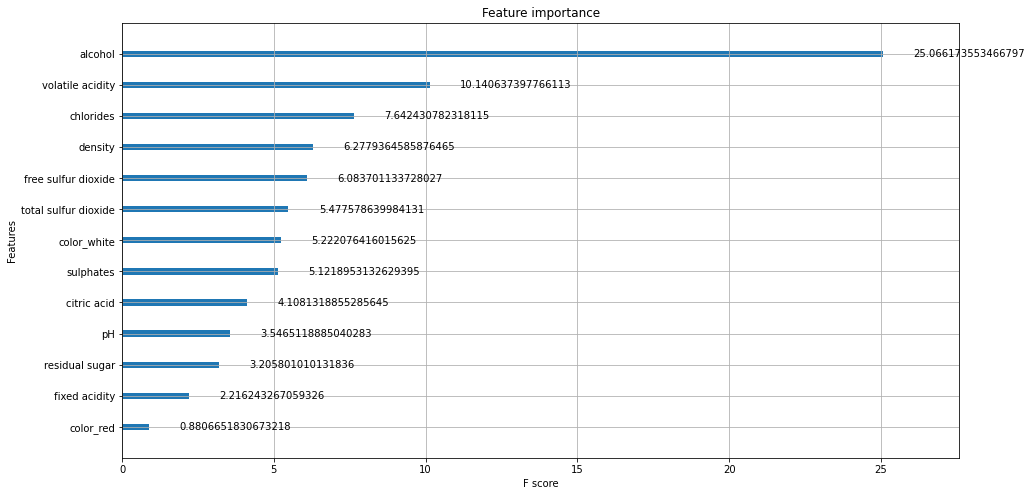

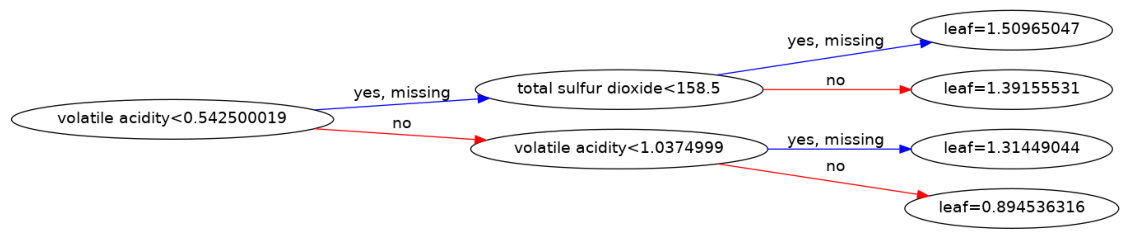

In [29]:
print('Feature Importances:')
print(best_model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
best_model.get_booster().feature_names = feature_data.feature_names
best_model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(best_model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(best_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()